In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [4]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial.distance import euclidean

In [5]:
dataset_root = Path('../../Dataset/ingested')

In [8]:
#df_file = sorted(list((dataset_root).glob('features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_spectral_features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_temporal_features*.csv')))[ 0 ]
#df_file = sorted(list((dataset_root).glob('fsfel_statistical_features*.csv')))[ 0 ]
df_files = sorted(list((dataset_root).glob('fsfel_all_features*.csv')))

In [9]:
df_files

[PosixPath('../../Dataset/ingested/fsfel_all_features_0.csv'),
 PosixPath('../../Dataset/ingested/fsfel_all_features_1.csv'),
 PosixPath('../../Dataset/ingested/fsfel_all_features_2.csv')]

In [12]:
df_features = pd.concat([ pd.read_csv( df_file, index_col = 'sample_name' ) for df_file in df_files ])


In [13]:
df_features

,Absolute energy,Area under the curve,Autocorrelation,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,...,Wavelet variance_0,Wavelet variance_1,Wavelet variance_2,Wavelet variance_3,Wavelet variance_4,Wavelet variance_5,Wavelet variance_6,Wavelet variance_7,Wavelet variance_8,Zero crossing rate
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,143.028305,2.776200,143.028305,10.898703,299.0,1196.0,0.000,0.307,0.000669,0.001338,...,0.020536,0.041642,0.076114,0.118772,0.159664,0.187189,0.199345,0.203901,0.209303,5.0
MAC000002-2012-11,142.307686,3.448940,142.307686,6.714764,299.0,1196.0,0.103,0.289,0.000669,0.001338,...,0.030100,0.042896,0.057508,0.077917,0.095408,0.108746,0.120687,0.133895,0.149320,9.0
MAC000002-2012-12,151.318359,3.555400,151.318359,7.013707,299.0,1196.0,0.104,0.293,0.000669,0.001338,...,0.031424,0.050123,0.071109,0.094537,0.114834,0.131182,0.146861,0.164570,0.184545,6.0
MAC000002-2013-01,154.403864,3.598440,154.403864,7.811695,299.0,1196.0,0.109,0.278,0.000669,0.001338,...,0.031152,0.054426,0.069617,0.089890,0.116362,0.145060,0.173281,0.200144,0.225378,4.0
MAC000002-2013-02,238.548989,3.817305,238.548989,8.363299,299.0,1196.0,0.088,0.288,0.000669,0.001338,...,0.038880,0.085373,0.162035,0.242712,0.310418,0.366311,0.415521,0.460266,0.502049,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000362-2013-12,19.297520,1.278995,19.297520,7.820106,298.0,1194.0,0.031,0.135,0.000670,0.001340,...,0.003881,0.006265,0.009709,0.013659,0.017521,0.020537,0.022489,0.023903,0.025350,2.0
MAC000362-2014-01,17.224751,1.229200,17.224751,7.416443,298.0,1194.0,0.031,0.126,0.000670,0.001340,...,0.003449,0.005210,0.007747,0.010369,0.013109,0.015600,0.017666,0.019536,0.021523,2.0
MAC000362-2014-02,15.567642,1.010265,15.567642,5.914056,298.0,1194.0,0.024,0.110,0.000670,0.001340,...,0.003868,0.005505,0.009020,0.012693,0.015399,0.016804,0.017027,0.016694,0.016467,3.0


# DBSCAN cluster visualization

## First transform in 2D than cluster with DBSCAN


In [14]:
def visualize_clusters_dbscan( reduced_data, eps=0.3, min_samples=10, reduction_name = '' ):

    X = reduced_data
    
    db = DBSCAN(eps=eps, min_samples=min_samples, 
                metric='euclidean', metric_params=None, 
                algorithm='auto', leaf_size=30, p=None).fit(X)
    
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_

    # Number of clusters in labels, ignoring noise if present.
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

    # #############################################################################
    # Plot result

    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]

    plt.figure( figsize = (14,8) )
    for k, col in zip(unique_labels, colors):

        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = labels == k

        xy = X[class_member_mask & core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=14,
        )

        xy = X[class_member_mask & ~core_samples_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.title(f"Reduction: {reduction_name} Estimated number of clusters: {n_clusters_}")
    plt.show()

In [15]:
data = df_features.values

/home/jupyter-mallibus/.conda/envs/py310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/jupyter-mallibus/.conda/envs/py310/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Estimated number of clusters: 18
Estimated number of noise points: 81
Silhouette Coefficient: 0.085


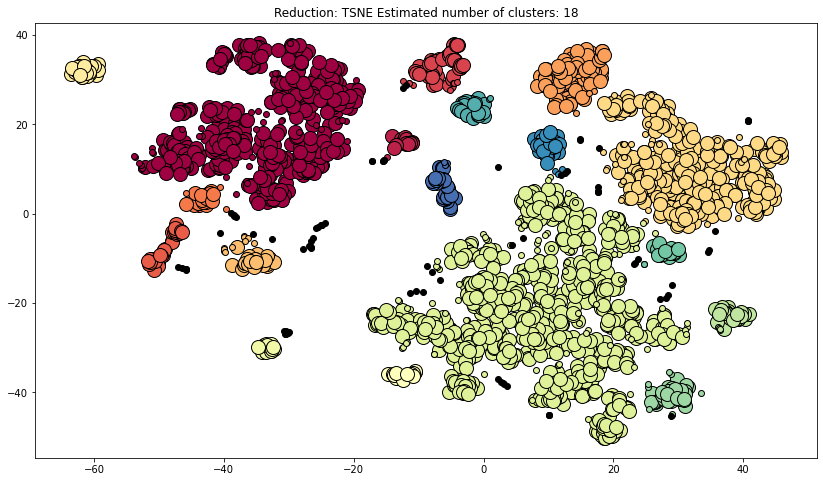

In [16]:
reduced_data = make_pipeline(StandardScaler(), TSNE(n_components=2)).fit_transform(data).astype( np.float64 )
visualize_clusters_dbscan( reduced_data, reduction_name = 'TSNE', eps = 3 )

In [17]:
df_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Absolute energy,2088.0,237.030831,622.595311,0.009789,33.956737,86.353367,199.662300,10468.051804
Area under the curve,2088.0,3.219130,2.652827,0.002110,1.669902,2.588452,3.906969,33.483065
Autocorrelation,2088.0,237.030831,622.595311,0.009789,33.956737,86.353367,199.662300,10468.051804
Centroid,2088.0,7.390823,1.105537,1.311732,6.926852,7.395385,7.821253,14.617021
ECDF Percentile Count_0,2088.0,297.049330,19.554770,0.000000,298.000000,298.000000,299.000000,299.000000
...,...,...,...,...,...,...,...,...
Wavelet variance_5,2088.0,0.352377,1.339136,0.000013,0.028116,0.079347,0.231288,23.601140
Wavelet variance_6,2088.0,0.415041,1.626383,0.000013,0.032160,0.090573,0.256090,28.823048
Wavelet variance_7,2088.0,0.474895,1.914315,0.000013,0.035136,0.101462,0.278166,34.029862
Wavelet variance_8,2088.0,0.537082,2.223200,0.000013,0.038005,0.113899,0.295954,39.595663


In [18]:
from collections import namedtuple

class Results(namedtuple('Results',['algo','param','n_clusters','n_outliers',
                                    'ratio_outliers','score'])):
    def __str__(self):
        return(f'algo={self.algo:6s}, '+
               f'param={self.param:4.3f}, '+
               f'n_clusters={self.n_clusters:4d}, '+
               f'n_outliers={self.n_outliers:5d}, '+
               f'ratio_outliers={self.ratio_outliers:0.3f}, '+
               f'score={self.score:0.3f}')

class PipeResults(namedtuple('PipeResults',['pca','tsne','result'])):
    def __str__(self):
        return((f'pca={self.pca:4d}, ' if not self.pca is None else 'pca=None, ') +
               (f'tsne={self.tsne:4d}, ' if not self.tsne is None else 'tsne=None, ') +
                f'{self.result}')
    

In [19]:
def scale_data( X, pca, tsne ):
    scaled_data =   StandardScaler().fit_transform(X)
    if not pca is None :
        np.random.seed(100)
        scaled_data = PCA( n_components = pca ).fit_transform(scaled_data)
    if not tsne is None :
        np.random.seed(100)
        scaled_data = TSNE( n_components = tsne ).fit_transform(scaled_data)
    scaled_data = scaled_data.astype( np.float64 )
    return scaled_data

def dbascan_bench_and_labels( X, eps ):
    np.random.seed(100)
    db = DBSCAN( eps= eps, 
                 min_samples = 10, 
                 metric='euclidean', 
                 metric_params=None, 
                 algorithm='auto', 
                 leaf_size=30, p=None ).fit(X)  
    
    labels = db.labels_
    n_clusters = len(set(labels)) - (1 if -1 in db.labels_ else 0)
    n_outliers = list(labels).count(-1)
    if n_clusters > 1 :
        score = metrics.silhouette_score(X, labels)
    else :
        score = np.nan
        
    return Results( algo = 'DBSCAN', 
                    param = eps,
                    n_clusters = n_clusters,
                    n_outliers = n_outliers,
                    ratio_outliers = n_outliers / len(X),
                    score = score ),labels

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
from tqdm import tqdm

In [22]:
df_features

,Absolute energy,Area under the curve,Autocorrelation,Centroid,ECDF Percentile Count_0,ECDF Percentile Count_1,ECDF Percentile_0,ECDF Percentile_1,ECDF_0,ECDF_1,...,Wavelet variance_0,Wavelet variance_1,Wavelet variance_2,Wavelet variance_3,Wavelet variance_4,Wavelet variance_5,Wavelet variance_6,Wavelet variance_7,Wavelet variance_8,Zero crossing rate
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,143.028305,2.776200,143.028305,10.898703,299.0,1196.0,0.000,0.307,0.000669,0.001338,...,0.020536,0.041642,0.076114,0.118772,0.159664,0.187189,0.199345,0.203901,0.209303,5.0
MAC000002-2012-11,142.307686,3.448940,142.307686,6.714764,299.0,1196.0,0.103,0.289,0.000669,0.001338,...,0.030100,0.042896,0.057508,0.077917,0.095408,0.108746,0.120687,0.133895,0.149320,9.0
MAC000002-2012-12,151.318359,3.555400,151.318359,7.013707,299.0,1196.0,0.104,0.293,0.000669,0.001338,...,0.031424,0.050123,0.071109,0.094537,0.114834,0.131182,0.146861,0.164570,0.184545,6.0
MAC000002-2013-01,154.403864,3.598440,154.403864,7.811695,299.0,1196.0,0.109,0.278,0.000669,0.001338,...,0.031152,0.054426,0.069617,0.089890,0.116362,0.145060,0.173281,0.200144,0.225378,4.0
MAC000002-2013-02,238.548989,3.817305,238.548989,8.363299,299.0,1196.0,0.088,0.288,0.000669,0.001338,...,0.038880,0.085373,0.162035,0.242712,0.310418,0.366311,0.415521,0.460266,0.502049,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAC000362-2013-12,19.297520,1.278995,19.297520,7.820106,298.0,1194.0,0.031,0.135,0.000670,0.001340,...,0.003881,0.006265,0.009709,0.013659,0.017521,0.020537,0.022489,0.023903,0.025350,2.0
MAC000362-2014-01,17.224751,1.229200,17.224751,7.416443,298.0,1194.0,0.031,0.126,0.000670,0.001340,...,0.003449,0.005210,0.007747,0.010369,0.013109,0.015600,0.017666,0.019536,0.021523,2.0
MAC000362-2014-02,15.567642,1.010265,15.567642,5.914056,298.0,1194.0,0.024,0.110,0.000670,0.001340,...,0.003868,0.005505,0.009020,0.012693,0.015399,0.016804,0.017027,0.016694,0.016467,3.0


In [23]:
def eps_search_space( scaled_data, steps = 100 ):
    distances = pd.DataFrame([[euclidean(scaled_data[i],scaled_data[j]) for i in range(j,scaled_data.shape[0])] for j in range(scaled_data.shape[0])])
    max_distance = distances.max().max()
    eps_min, eps_max  = max_distance * 0.01, max_distance * 0.9
    print( f'scaled_data.shape : {scaled_data.shape}')
    print( f'max_distance : {max_distance}')
    print( f'search_space : {eps_min},{eps_max},')
    return np.linspace( eps_min, eps_max, steps )


In [24]:
%%time
results_list = []
labels_list = []
for pca in tqdm([ None, 5, 10, 20, 30 ]) :    
    if (pca is None) or (pca < df_features.shape[1]):
        for tsne in [ None, 2 ] :

            scaled_data = scale_data( df_features, pca, tsne )

            for eps in eps_search_space( scaled_data ) :
                clustering_benchmark, labels = dbascan_bench_and_labels( scaled_data, eps )
                results_list.append( { 'pca' : pca,'tsne' : tsne, **clustering_benchmark._asdict() } )
                labels_list.append( labels )

  0%|          | 0/5 [00:00<?, ?it/s]

scaled_data.shape : (2088, 390)
max_distance : 178.56319758824955
search_space : 1.7856319758824954,160.7068778294246,
scaled_data.shape : (2088, 2)
max_distance : 124.48077982501532
search_space : 1.2448077982501533,112.03270184251379,


 20%|██        | 1/5 [00:32<02:10, 32.69s/it]

scaled_data.shape : (2088, 5)
max_distance : 155.9064733838401
search_space : 1.5590647338384012,140.3158260454561,
scaled_data.shape : (2088, 2)
max_distance : 134.51705112071852
search_space : 1.3451705112071852,121.06534600864667,


 40%|████      | 2/5 [00:59<01:27, 29.16s/it]

scaled_data.shape : (2088, 10)
max_distance : 173.43966564827394
search_space : 1.7343966564827396,156.09569908344656,
scaled_data.shape : (2088, 2)
max_distance : 134.2211689455157
search_space : 1.342211689455157,120.79905205096414,


 60%|██████    | 3/5 [01:27<00:57, 28.57s/it]

scaled_data.shape : (2088, 20)
max_distance : 177.63755604035498
search_space : 1.7763755604035498,159.8738004363195,
scaled_data.shape : (2088, 2)
max_distance : 118.11131760387097
search_space : 1.1811131760387097,106.30018584348387,


 80%|████████  | 4/5 [01:54<00:28, 28.14s/it]

scaled_data.shape : (2088, 30)
max_distance : 178.2656263475355
search_space : 1.7826562634753549,160.43906371278194,
scaled_data.shape : (2088, 2)
max_distance : 118.92508532540889
search_space : 1.1892508532540889,107.032576792868,


100%|██████████| 5/5 [02:22<00:00, 28.52s/it]

CPU times: user 3min 20s, sys: 47 s, total: 4min 7s
Wall time: 2min 22s


In [48]:
pd.DataFrame(results_list)

,pca,tsne,algo,param,n_clusters,n_outliers,ratio_outliers,score
0,NaN,NaN,DBSCAN,1.110889,0,698,1.000000,NaN
1,NaN,NaN,DBSCAN,2.109566,0,698,1.000000,NaN
2,NaN,NaN,DBSCAN,3.108244,1,682,0.977077,NaN
3,NaN,NaN,DBSCAN,4.106922,3,599,0.858166,-0.231153
4,NaN,NaN,DBSCAN,5.105599,3,486,0.696275,-0.147309
...,...,...,...,...,...,...,...,...
995,30.0,2.0,DBSCAN,68.766715,1,0,0.000000,NaN
996,30.0,2.0,DBSCAN,69.482197,1,0,0.000000,NaN
997,30.0,2.0,DBSCAN,70.197680,1,0,0.000000,NaN
998,30.0,2.0,DBSCAN,70.913162,1,0,0.000000,NaN


In [49]:
result_summary = (pd.DataFrame(results_list)
                  .assign( xref = lambda x : x.index )
                 .query( 'n_clusters > 1' )
                 .query( 'ratio_outliers < 0.1' )
                 .query( 'score > 0' )
                 .sort_values('score', ascending = False)
                 .groupby( 'n_clusters' )
                 .first()
                 .pipe( lambda x : x.set_index( zip( x.index, x.xref ) ) )
                )
result_summary

,,pca,tsne,algo,param,n_outliers,ratio_outliers,score,xref
2,206,5.0,2.0,DBSCAN,6.482481,52,0.074499,0.449210,206
3,306,5.0,2.0,DBSCAN,5.345100,0,0.000000,0.072961,306
4,905,30.0,2.0,DBSCAN,4.373286,5,0.007163,0.034493,905
5,105,20.0,2.0,DBSCAN,4.012273,19,0.027221,0.104368,105
7,704,20.0,2.0,DBSCAN,3.599093,12,0.017192,0.108658,704
9,504,10.0,2.0,DBSCAN,3.423878,3,0.004298,0.203571,504
10,303,5.0,2.0,DBSCAN,3.090532,15,0.021490,0.367371,303
11,104,NaN,2.0,DBSCAN,3.355853,26,0.037249,0.168882,104
12,503,10.0,2.0,DBSCAN,2.754152,34,0.048711,0.458699,503
14,703,20.0,2.0,DBSCAN,2.895095,36,0.051576,0.402597,703


<AxesSubplot:>

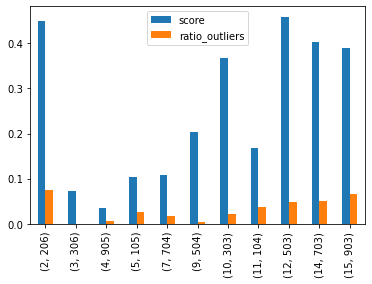

In [50]:
result_summary[['score','ratio_outliers']].plot(kind='bar')

In [51]:
show_xref = 303

In [52]:
( _ , pca, tsne, _ , eps , *_ ) = (result_summary
                                     .reset_index( level = 1 )
                                     .query( 'level_1 == @show_xref' )
                                     .iloc[0]
                                    )
pca = int(pca)
tsne = int(tsne)

5 2 3.090531962273565
Estimated number of clusters: 10
Estimated number of noise points: 15
Silhouette Coefficient: 0.367


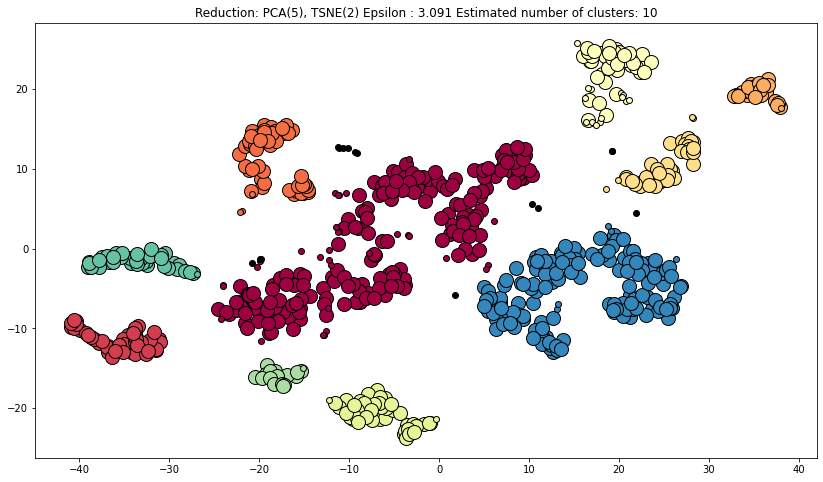

In [53]:
print(pca, tsne, eps)
scaled_data = scale_data( df_features, pca = pca, tsne = tsne )
visualize_clusters_dbscan( scaled_data, reduction_name = f'PCA({pca}), TSNE({tsne}) Epsilon : {eps:0.3f}', eps = eps )

In [54]:
df_series_file = sorted(list((dataset_root).glob('series*.csv')))[ 0 ]
print(f'Reading series from {df_series_file}')
df_series = pd.read_csv( df_series_file , index_col = 'sample_name' )
df_series.head()

Reading series from ../../Dataset/ingested/series_0.csv


,01-00:00:00,01-00:30:00,01-01:00:00,01-01:30:00,01-02:00:00,01-02:30:00,01-03:00:00,01-03:30:00,01-04:00:00,01-04:30:00,...,31-19:00:00,31-19:30:00,31-20:00:00,31-20:30:00,31-21:00:00,31-21:30:00,31-22:00:00,31-22:30:00,31-23:00:00,31-23:30:00
sample_name,,,,,,,,,,,,,,,,,,,,,
MAC000002-2012-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.346,0.291,0.333,0.368,0.951,1.445,0.946,0.305,0.243,0.252
MAC000002-2012-11,0.252,0.241,0.230,0.209,0.231,0.193,0.186,0.148,0.183,0.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAC000002-2012-12,0.215,0.217,0.237,0.204,0.243,0.199,0.237,0.125,0.104,0.115,...,0.227,0.228,1.168,0.272,0.237,0.231,0.263,0.220,0.236,0.229
MAC000002-2013-01,0.219,0.241,0.191,0.235,0.182,0.229,0.194,0.201,0.122,0.099,...,0.194,0.214,1.078,0.227,0.250,0.240,0.281,0.248,0.266,0.257
MAC000002-2013-02,0.215,0.284,0.313,0.286,0.204,0.269,0.204,0.266,0.216,0.223,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
labels = labels_list[ show_xref ]
set(labels)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [56]:
def show_cluster_sample( df_series, labels, num_samples_to_show, cluster, figsize = (14,6) ):
    name = f'#{cluster}' if cluster >= 0 else 'Outliers'
    ( df_series
      .assign( cluster = labels )
      .reset_index()
      .groupby(['cluster','sample_name'])
      .first()
      .loc[(cluster,)]
      .sample( num_samples_to_show, replace = False )  
      .T
    ).plot( figsize = (14,6), subplots = True, title = f'{num_samples_to_show} samples of Cluster {name}' )
    plt.show()


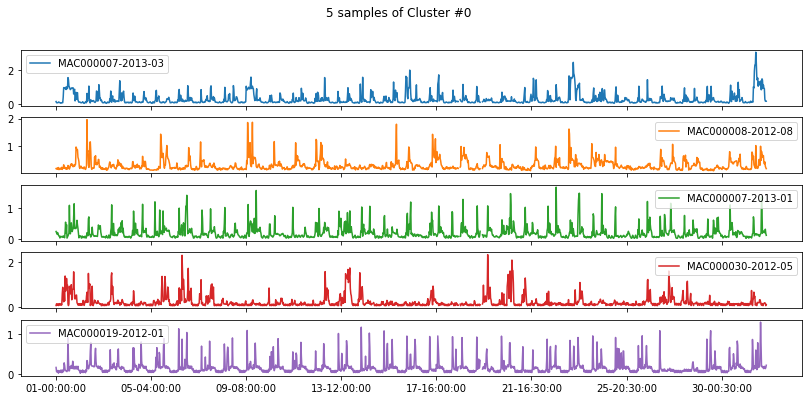

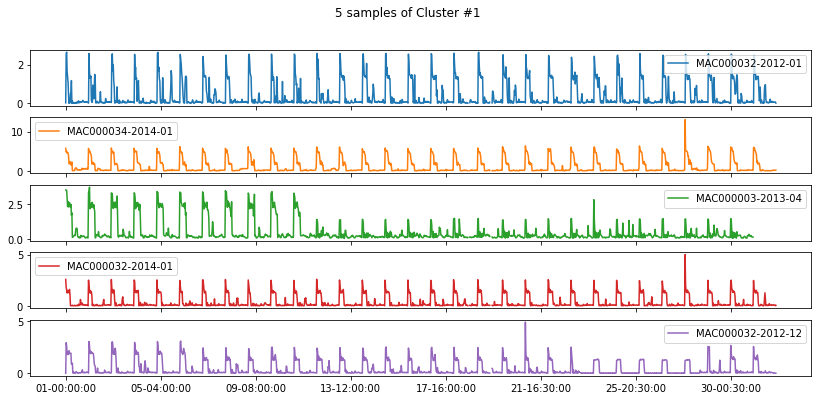

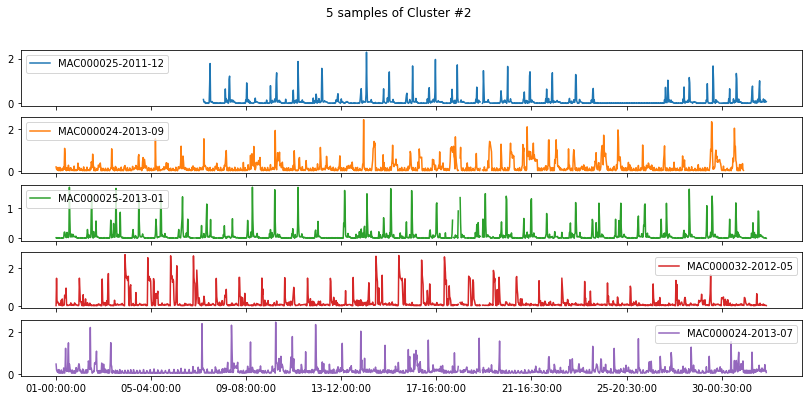

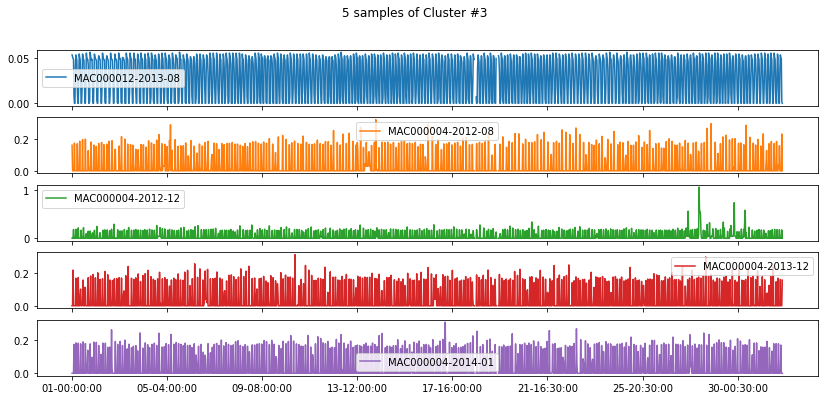

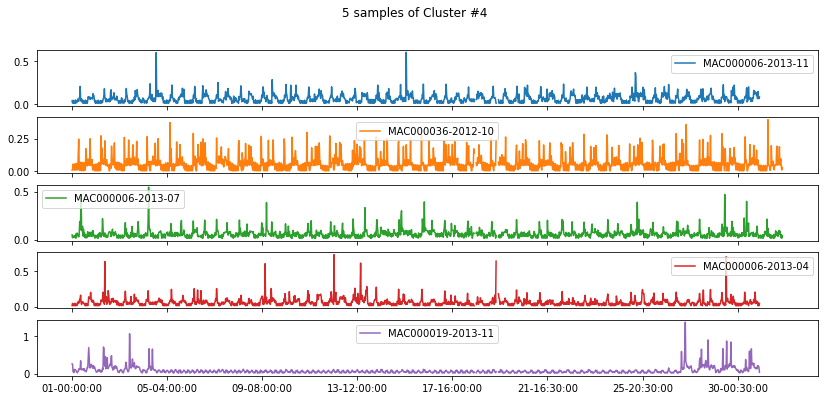

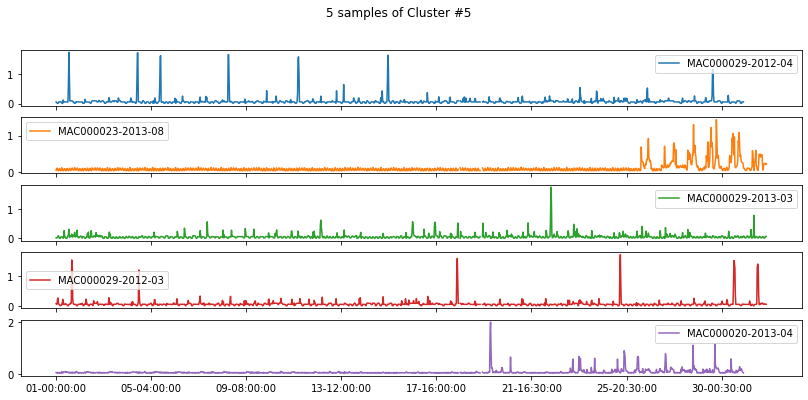

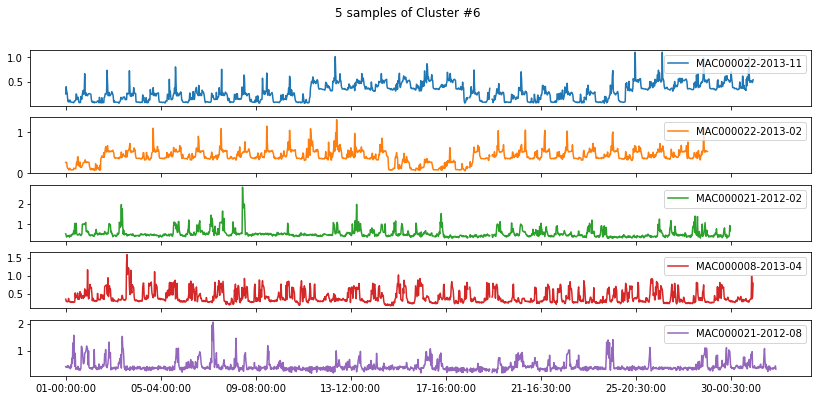

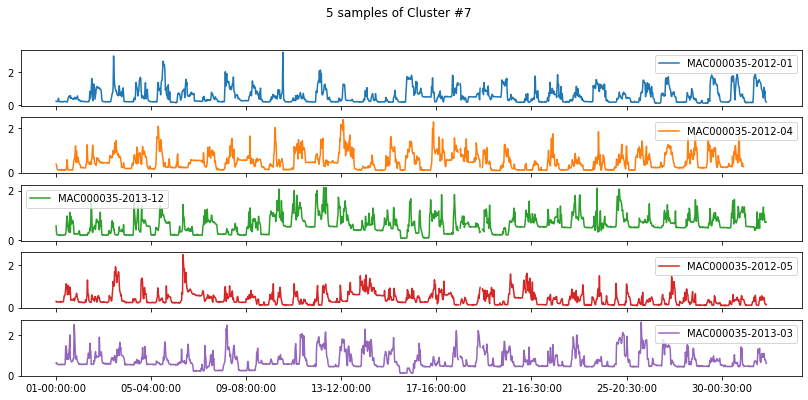

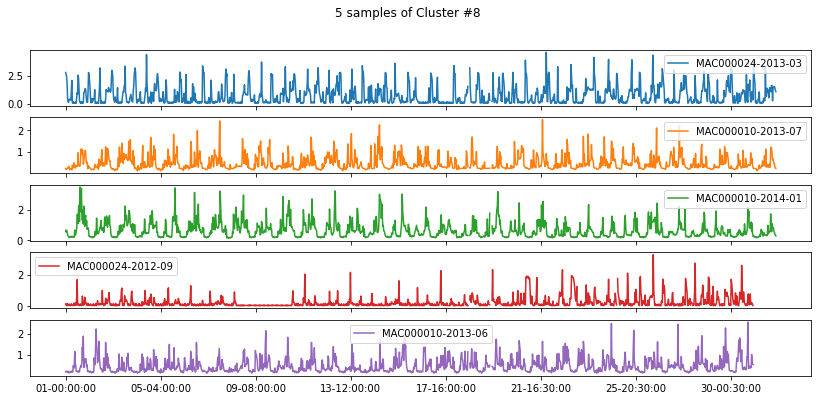

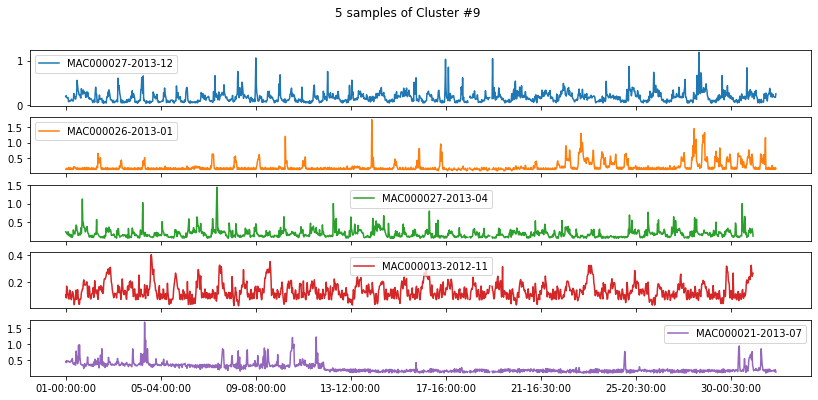

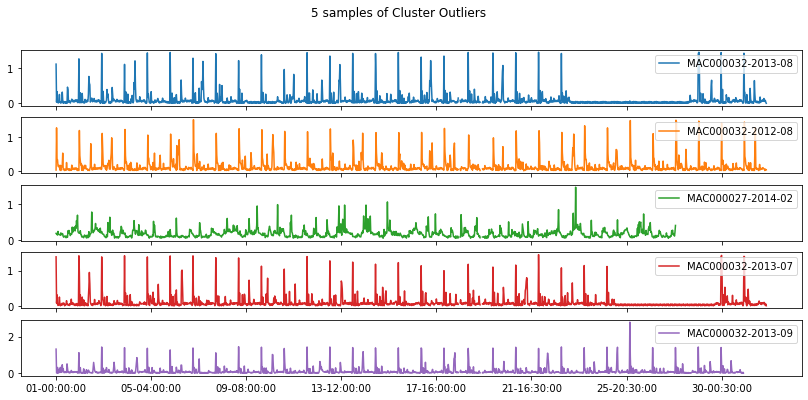

In [57]:
for c in set(labels):
    show_cluster_sample( df_series, labels, num_samples_to_show = 5, cluster = c )